# 1. Import Packages

In [1]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

2024-08-29 09:19:12.798934: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 09:19:12.799024: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 09:19:12.927450: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules loaded


# 2. Create Datadrame with images

In [2]:
data_path = "/kaggle/input/corn-or-maize-leaf-disease-dataset/data" 

images = []
labels = []

for subfolder in os.listdir(data_path):
    
    subfolder_path = os.path.join(data_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
  
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
    
        labels.append(subfolder)
 
data = pd.DataFrame({'image': images, 'label': labels})

# 3. Data Visualization

In [3]:
data.head()


,image,label
0,/kaggle/input/corn-or-maize-leaf-disease-datas...,Common_Rust
1,/kaggle/input/corn-or-maize-leaf-disease-datas...,Common_Rust
2,/kaggle/input/corn-or-maize-leaf-disease-datas...,Common_Rust
3,/kaggle/input/corn-or-maize-leaf-disease-datas...,Common_Rust
4,/kaggle/input/corn-or-maize-leaf-disease-datas...,Common_Rust


In [4]:
data.shape


(4188, 2)

In [5]:
strat = data['label']
train_df, dummy_df = train_test_split(data,  train_size= 0.81, shuffle= True, random_state= 123, stratify= strat)

strat = dummy_df['label']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

In [6]:
print("Training set shape:", train_df.shape)
print("Validation set shape:", valid_df.shape)
print("Test set shape:", test_df.shape)

Training set shape: (3392, 2)
Validation set shape: (398, 2)
Test set shape: (398, 2)


In [7]:
batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='image', y_col='label', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='image', y_col='label', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='image', y_col='label', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 3392 validated image filenames belonging to 4 classes.
Found 398 validated image filenames belonging to 4 classes.
Found 398 validated image filenames belonging to 4 classes.


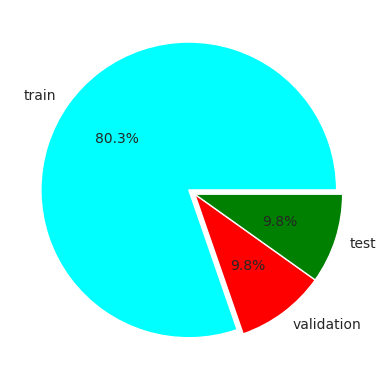

<Figure size 640x480 with 0 Axes>

In [8]:
plt.pie([len(train_gen), len(valid_gen), len(test_gen)],
        labels=['train', 'validation', 'test'], autopct='%.1f%%', colors=['aqua', 'red', 'green'], explode=(0.05, 0, 0))
plt.show()
plt.savefig('dataset_pie.png')

In [9]:
print(train_gen.class_indices)
print(test_gen.class_indices)
print(valid_gen.class_indices)

{'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}
{'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}
{'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}


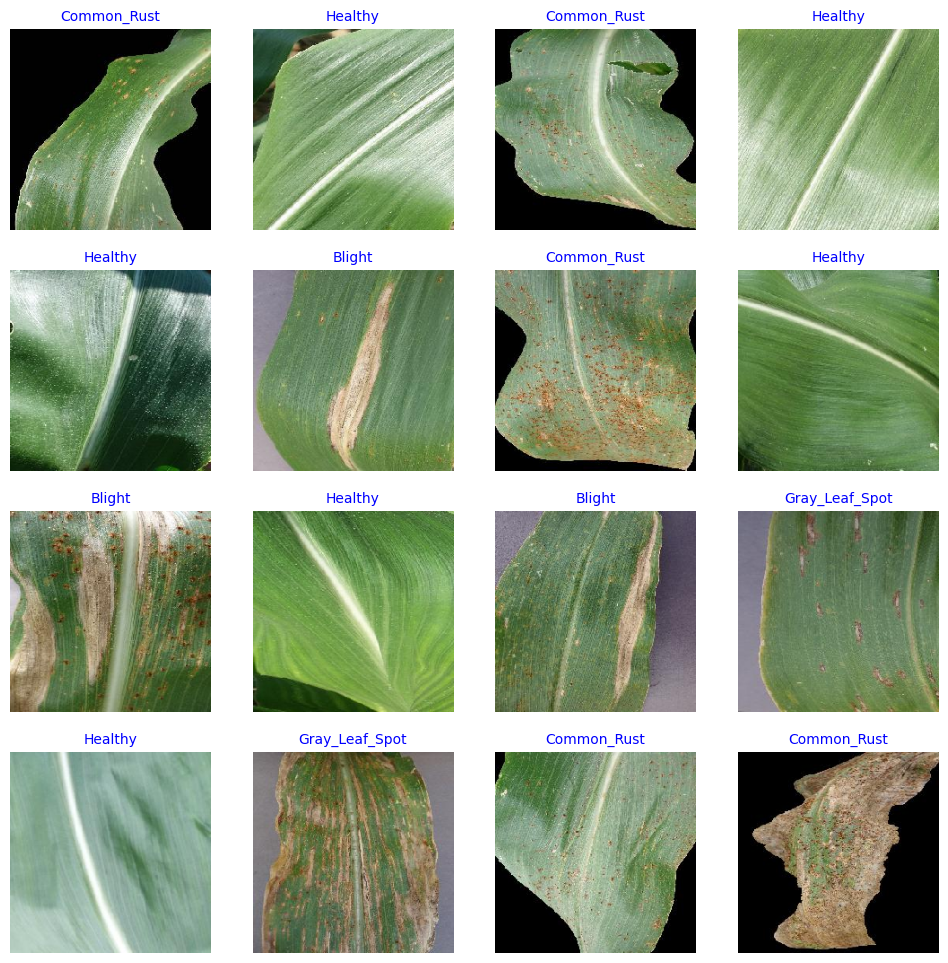

In [10]:
g_dict = train_gen.class_indices      
classes = list(g_dict.keys())       
images, labels = next(train_gen)      

plt.figure(figsize= (12, 12))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'blue', fontsize= 10)
    plt.axis('off')
plt.show()

# 4. CNN Model

In [11]:
model = Sequential()

model.add(tf.keras.layers.InputLayer(input_shape=(224, 224, 3)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))  
model.add(BatchNormalization())


model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))  
model.add(BatchNormalization())


model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))  
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))  
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())  

model.add(Dropout(0.3))  

model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))


model.add(Dense(4, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))  



model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 110, 110, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 53, 53, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 51, 51, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 49, 49, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 22, 22, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 20, 20, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 430,212 (1.64 MB)

 Trainable params: 429,572 (1.64 MB)

 Non-trainable params: 640 (2.50 KB)

# 5. Callback and Model Compile

In [12]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.98):
            print("\nReached 98% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_gen,
    epochs=100,
    batch_size=32,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[callbacks]
)


Epoch 1/100
  1/106 ━━━━━━━━━━━━━━━━━━━━ 52:16 30s/step - accuracy: 0.3438 - loss: 1.6657

I0000 00:00:1724923198.646047     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


106/106 ━━━━━━━━━━━━━━━━━━━━ 52s 207ms/step - accuracy: 0.6196 - loss: 1.1225 - val_accuracy: 0.3643 - val_loss: 5.4954
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - accuracy: 0.7890 - loss: 0.5989 - val_accuracy: 0.7638 - val_loss: 0.5967
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - accuracy: 0.8212 - loss: 0.4891 - val_accuracy: 0.6055 - val_loss: 1.2930
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - accuracy: 0.8633 - loss: 0.4112 - val_accuracy: 0.8492 - val_loss: 0.4874
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - accuracy: 0.8576 - loss: 0.3995 - val_accuracy: 0.6859 - val_loss: 1.0409
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - accuracy: 0.8712 - loss: 0.3560 - val_accuracy: 0.7412 - val_loss: 0.7423
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - accuracy: 0.8883 - loss: 0.3217 - val_accuracy: 0.8266 - val_loss: 0.8032
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - accuracy: 0.8762 - loss: 0.344

# 6. Accuracy and Loss Curve

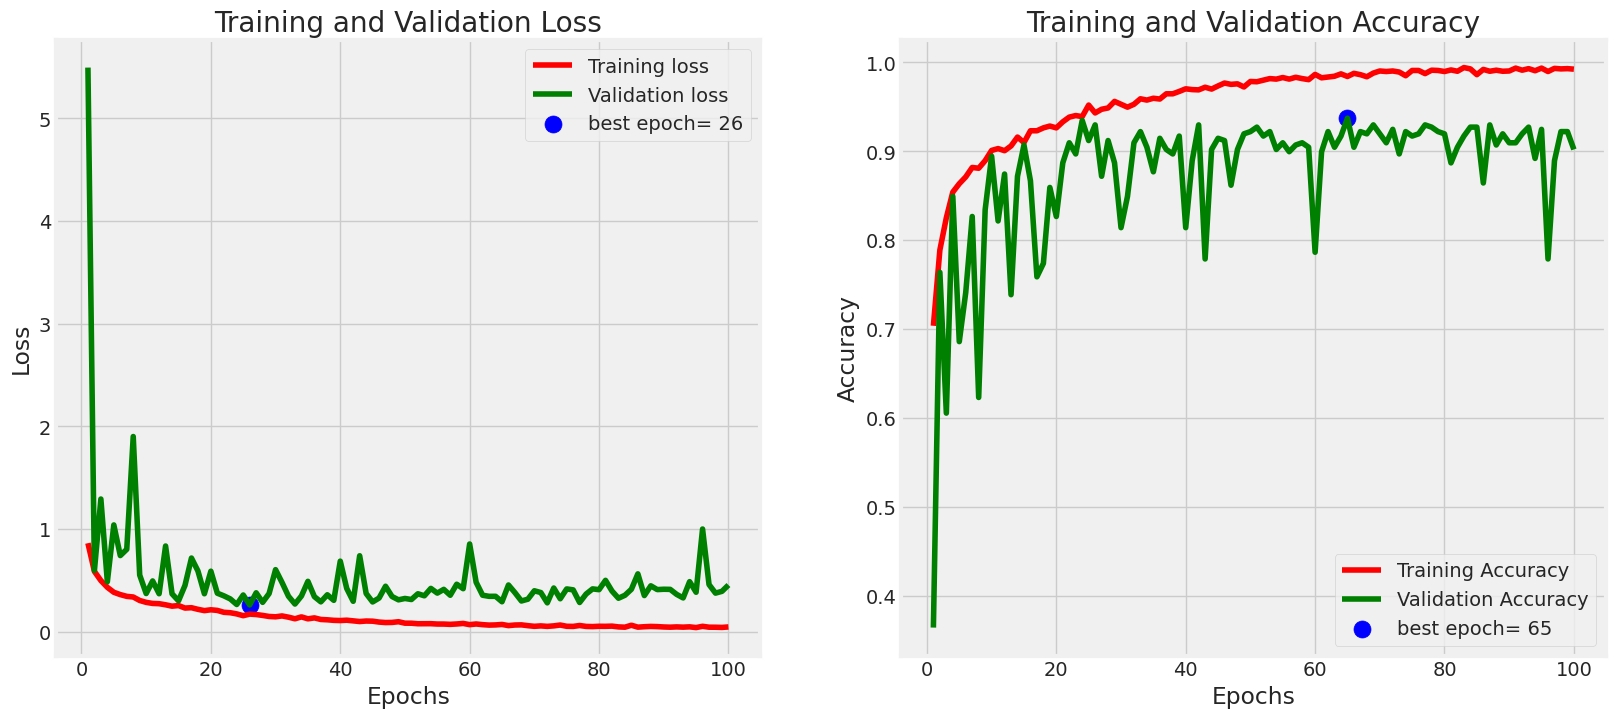

In [13]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# 7. Accuracy Score

In [14]:
loss, accuracy = model.evaluate(valid_gen)
print("Accuracy score:", accuracy)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.8961 - loss: 0.5322
Accuracy score: 0.8994975090026855


In [15]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

199/199 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9806 - loss: 0.0716
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9018 - loss: 0.5094  
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8902 - loss: 0.4911   
Train Loss:  0.07432983070611954
Train Accuracy:  0.979363203048706
--------------------
Valid Loss:  0.5135498046875
Valid Accuracy:  0.9020100235939026
--------------------
Test Loss:  0.48688292503356934
Test Accuracy:  0.8919597864151001


# 8. Classification Report

In [16]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step


In [17]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))


                precision    recall  f1-score   support

        Blight       0.94      0.70      0.80       109
   Common_Rust       0.99      0.94      0.97       124
Gray_Leaf_Spot       0.61      0.94      0.74        54
       Healthy       0.97      1.00      0.98       111

      accuracy                           0.89       398
     macro avg       0.88      0.90      0.87       398
  weighted avg       0.92      0.89      0.89       398



# 9. Confusion Matrix

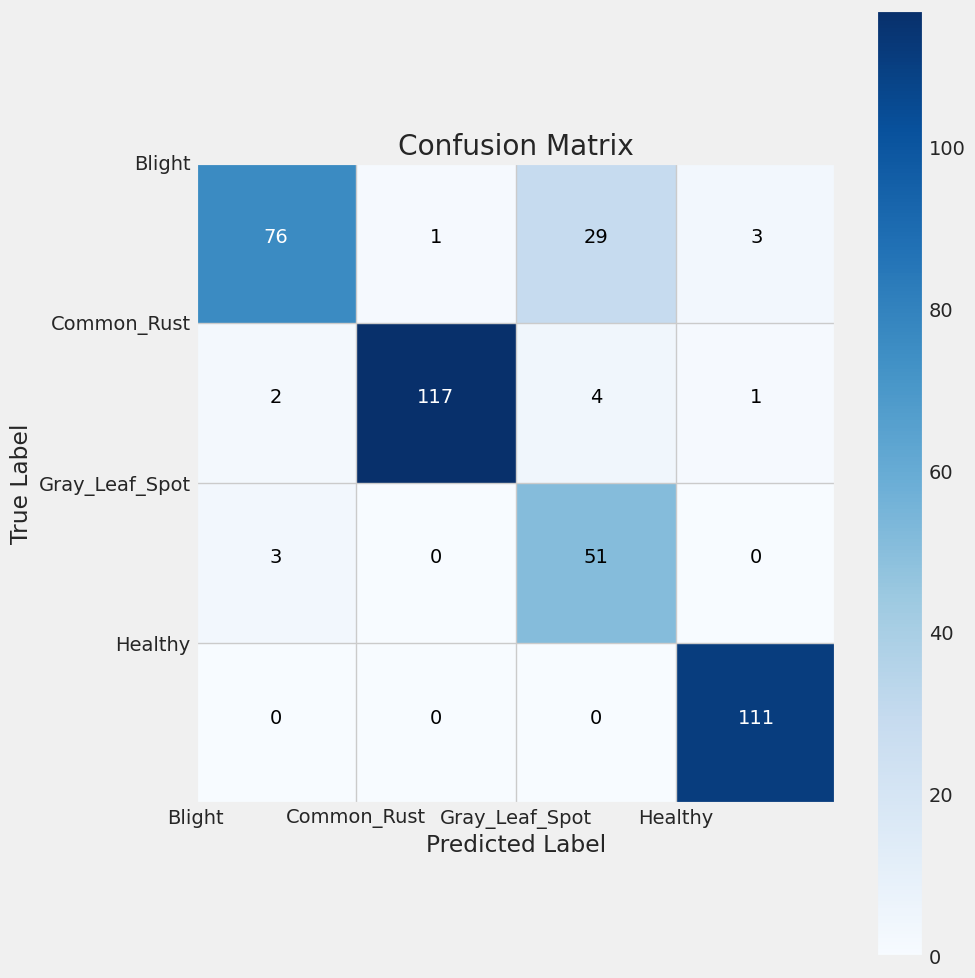

In [18]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks - 0.5, classes)  
plt.yticks(tick_marks - 0.5, classes) 


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

# 10. Model Save

In [19]:
model.save('model2.h5')


# 11. ROC Curve

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


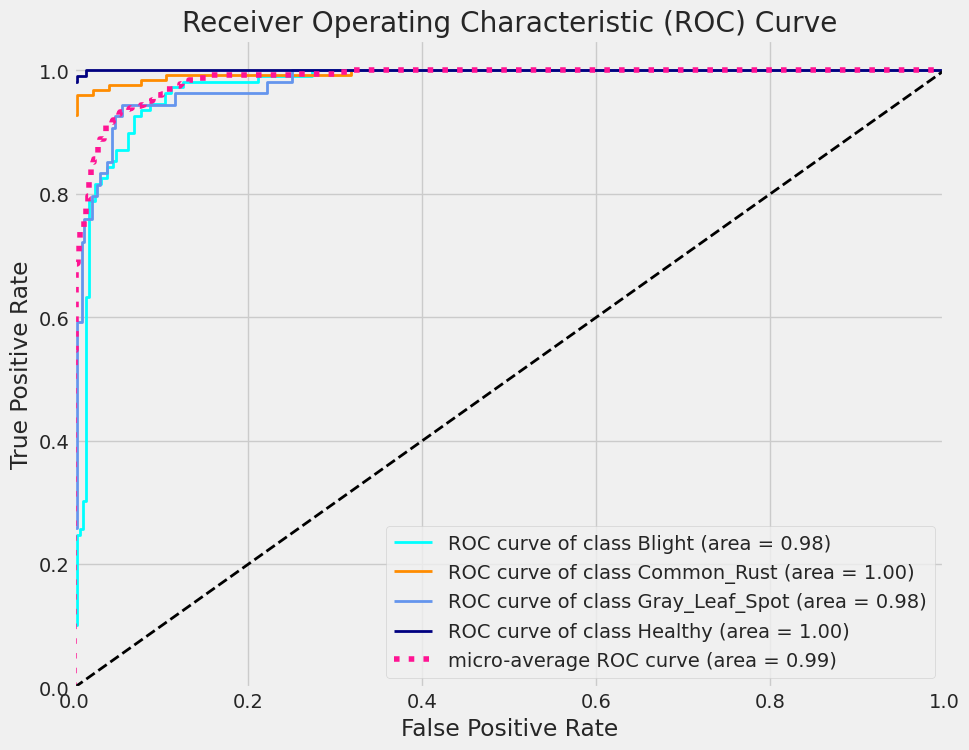

In [20]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import itertools


n_classes = len(classes)

y_true = label_binarize(test_gen.classes, classes=range(n_classes))
y_pred_probs = model.predict(test_gen)  # Ensure these are the predicted probabilities

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(10, 8))
colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue', 'navy', 'deeppink', 'seagreen'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# 12. AUC Curve

In [21]:
from sklearn.metrics import roc_auc_score

auc_scores = {}
for i in range(n_classes):
    auc_scores[classes[i]] = roc_auc_score(y_true[:, i], y_pred_probs[:, i])

for class_name, auc_score in auc_scores.items():
    print(f"AUC for class {class_name}: {auc_score:.2f}")

micro_auc = roc_auc_score(y_true, y_pred_probs, average="micro")
print(f"Micro-average AUC: {micro_auc:.2f}")

macro_auc = roc_auc_score(y_true, y_pred_probs, average="macro")
print(f"Macro-average AUC: {macro_auc:.2f}")

AUC for class Blight: 0.98
AUC for class Common_Rust: 1.00
AUC for class Gray_Leaf_Spot: 0.98
AUC for class Healthy: 1.00
Micro-average AUC: 0.99
Macro-average AUC: 0.99


# 13. ResNet50 Model

In [22]:
from keras.applications import ResNet50
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model

resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_base.trainable = False

inputs = Input(shape=(224, 224, 3))

x = resnet_base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)
resnet_model = Model(inputs, outputs)

resnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    
)

resnet_model.fit(train_gen, epochs=3, validation_data=valid_gen)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/3
  3/106 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.2830 - loss: 2.0139  

W0000 00:00:1724924441.062120     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


105/106 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7428 - loss: 0.7133

W0000 00:00:1724924454.953057     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


106/106 ━━━━━━━━━━━━━━━━━━━━ 32s 174ms/step - accuracy: 0.7445 - loss: 0.7083 - val_accuracy: 0.9472 - val_loss: 0.1590
Epoch 2/3
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - accuracy: 0.9155 - loss: 0.2314 - val_accuracy: 0.9246 - val_loss: 0.1998
Epoch 3/3
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - accuracy: 0.9288 - loss: 0.1970 - val_accuracy: 0.9372 - val_loss: 0.1497


In [23]:
test_loss, test_acc = resnet_model.evaluate(test_gen, verbose=0)
print('\naccuracy:', test_acc, '  loss: ',test_loss)


accuracy: 0.9170854091644287   loss:  0.212307870388031


 5/13 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

W0000 00:00:1724924486.389489     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 366ms/step


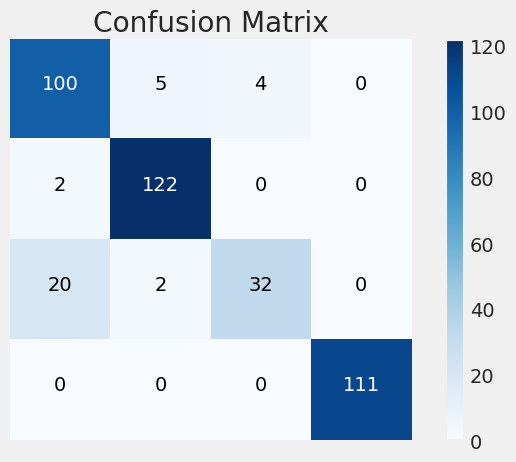

In [24]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools

test_preds = resnet_model.predict(test_gen)
predicted_labels = np.argmax(test_preds, axis=1)

cm = confusion_matrix(test_gen.classes, predicted_labels)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = list(test_gen.class_indices.keys())
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Remove the axes
plt.gca().set_axis_off()
plt.gca().xaxis.set_ticks_position('none') 
plt.gca().yaxis.set_ticks_position('none') 

plt.show()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


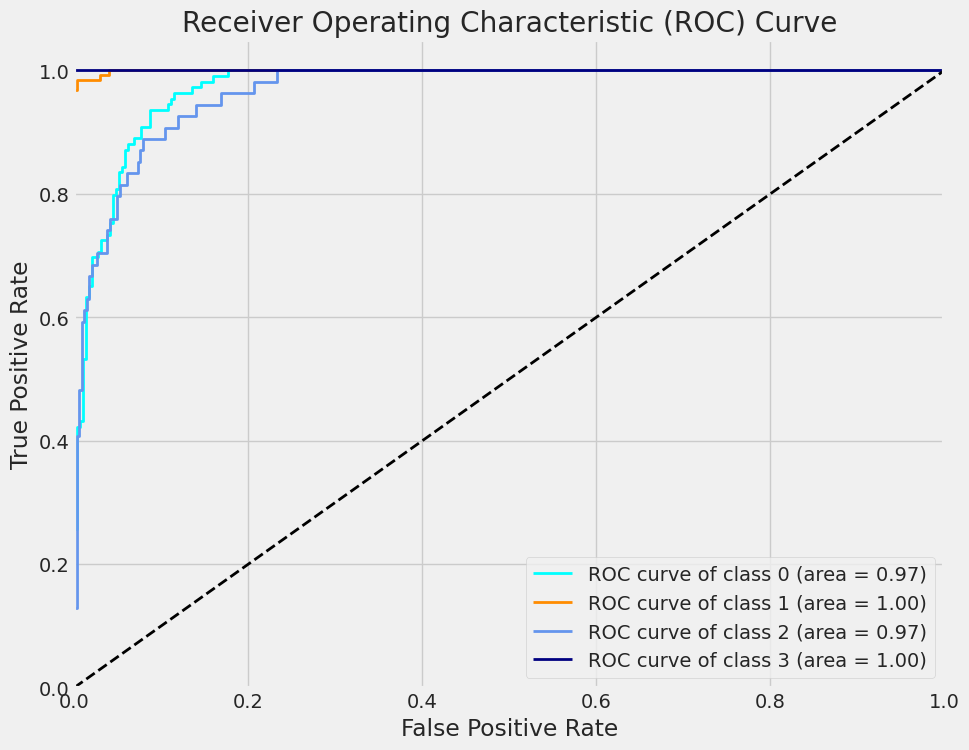

AUC for class 0: 0.97
AUC for class 1: 1.00
AUC for class 2: 0.97
AUC for class 3: 1.00
Micro-averaged AUC: 0.99


In [25]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

true_labels = label_binarize(test_gen.classes, classes=[0, 1, 2, 3])
n_classes = true_labels.shape[1]

predicted_probs = resnet_model.predict(test_gen)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], predicted_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(true_labels.ravel(), predicted_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'navy'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

for i in range(n_classes):
    print(f'AUC for class {i}: {roc_auc[i]:.2f}')
print(f'Micro-averaged AUC: {roc_auc["micro"]:.2f}')


# 14. VGG16 Model

In [26]:
from keras.applications import VGG16
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model

vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16_base.trainable = False

inputs = Input(shape=(224, 224, 3))

x = vgg16_base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)
vgg16_model = Model(inputs, outputs)

vgg16_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

vgg16_model.fit(train_gen, epochs=3, validation_data=valid_gen)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/3


2024-08-29 09:41:38.634917: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.63498, expected 3.85968
2024-08-29 09:41:38.634973: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.55784, expected 5.78254
2024-08-29 09:41:38.634988: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.61282, expected 5.83752
2024-08-29 09:41:38.635005: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.34499, expected 5.56968
2024-08-29 09:41:38.635020: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.25159, expected 5.47629
2024-08-29 09:41:38.635031: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.43964, expected 4.66434
2024-08-29 09:41:38.635043: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.54333, expected 5.76803
2024-08-29 09:41:38.635054: E external/local_xla/xla/se

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6174 - loss: 3.7406

2024-08-29 09:42:05.993706: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.83962, expected 3.23333
2024-08-29 09:42:05.993761: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.16738, expected 3.5611
2024-08-29 09:42:05.993770: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 4.08791, expected 3.48163
2024-08-29 09:42:05.993778: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 4.25991, expected 3.65362
2024-08-29 09:42:05.993786: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10: 4.65359, expected 4.04731
2024-08-29 09:42:05.993794: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 4.61877, expected 4.01249
2024-08-29 09:42:05.993802: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.09804, expected 2.49176
2024-08-29 09:42:05.993810: E external/local_xla/xla/

106/106 ━━━━━━━━━━━━━━━━━━━━ 39s 188ms/step - accuracy: 0.6183 - loss: 3.7230 - val_accuracy: 0.8492 - val_loss: 0.4557
Epoch 2/3
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - accuracy: 0.8123 - loss: 0.5430 - val_accuracy: 0.8794 - val_loss: 0.3496
Epoch 3/3
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.8258 - loss: 0.4688 - val_accuracy: 0.8744 - val_loss: 0.3219


In [27]:
test_loss, test_acc = vgg16_model.evaluate(test_gen, verbose=0)
print('\naccuracy:', test_acc, '  loss: ',test_loss)


accuracy: 0.8592965006828308   loss:  0.364122599363327


# 15. MobileNetV2 Model

In [28]:
from keras.applications import MobileNetV2
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model

mobilenetv2_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
mobilenetv2_base.trainable = False

inputs = Input(shape=(224, 224, 3))

x = mobilenetv2_base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)
mobilenetv2_model = Model(inputs, outputs)

mobilenetv2_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

mobilenetv2_model.fit(train_gen, epochs=3, validation_data=valid_gen)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/3
106/106 ━━━━━━━━━━━━━━━━━━━━ 31s 185ms/step - accuracy: 0.7122 - loss: 0.7230 - val_accuracy: 0.8568 - val_loss: 0.3463
Epoch 2/3
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - accuracy: 0.8098 - loss: 0.4388 - val_accuracy: 0.8467 - val_loss: 0.3489
Epoch 3/3
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - accuracy: 0.8322 - loss: 0.3718 - val_accuracy: 0.8593 - val_loss: 0.3163


In [29]:
test_loss, test_acc = mobilenetv2_model.evaluate(test_gen, verbose=0)
print('\naccuracy:', test_acc, '  loss: ',test_loss)


accuracy: 0.8316583037376404   loss:  0.363554447889328


# 16. DenseNet121 Model

In [30]:
from keras.applications import DenseNet121
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model

densenet121_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
densenet121_base.trainable = False

inputs = Input(shape=(224, 224, 3))

x = densenet121_base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)
densenet121_model = Model(inputs, outputs)

densenet121_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

densenet121_model.fit(train_gen, epochs=3, validation_data=valid_gen)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/3
106/106 ━━━━━━━━━━━━━━━━━━━━ 64s 310ms/step - accuracy: 0.6863 - loss: 1.3169 - val_accuracy: 0.8618 - val_loss: 0.3151
Epoch 2/3
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - accuracy: 0.8390 - loss: 0.4000 - val_accuracy: 0.8719 - val_loss: 0.3335
Epoch 3/3
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.8552 - loss: 0.3475 - val_accuracy: 0.8920 - val_loss: 0.2805


In [31]:
test_loss, test_acc = densenet121_model.evaluate(test_gen, verbose=0)
print('\naccuracy:', test_acc, '  loss: ',test_loss)


accuracy: 0.8517587780952454   loss:  0.30490249395370483


# 17. Lime using VGG16 model

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


  0%|          | 0/1000 [00:00<?, ?it/s]

2024-08-29 09:45:23.702795: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.17844, expected 3.56217
2024-08-29 09:45:23.702849: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.52289, expected 2.90662
2024-08-29 09:45:23.702859: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 4.66917, expected 4.05289
2024-08-29 09:45:23.702867: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 4.67338, expected 4.0571
2024-08-29 09:45:23.702875: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31: 4.6813, expected 4.06503
2024-08-29 09:45:23.702883: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 62: 4.79963, expected 4.18336
2024-08-29 09:45:23.702891: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 63: 4.73133, expected 4.11506
2024-08-29 09:45:23.702898: E external/local_xla/xl

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


W0000 00:00:1724924729.586802     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

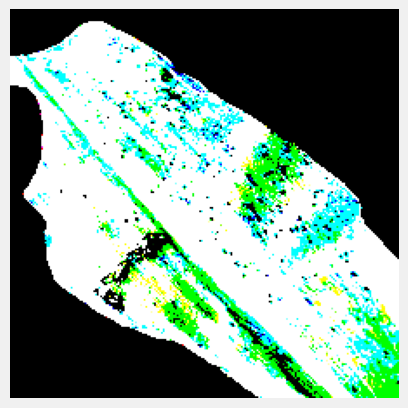

In [32]:
import lime
import lime.lime_image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from skimage.segmentation import mark_boundaries
from PIL import Image  
import matplotlib.pyplot as plt
import numpy as np

model = VGG16(weights='imagenet')

explainer = lime.lime_image.LimeImageExplainer()

img = np.array(Image.open('/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Common_Rust/Corn_Common_Rust (100).JPG').resize((224, 224)))
img = preprocess_input(img)

explanation = explainer.explain_instance(img, model.predict, top_labels=5, hide_color=0, num_samples=1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.axis('off')
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

# 18. Lime using ResNet50 Model

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━

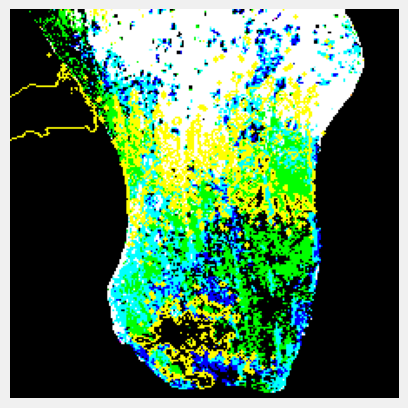

In [33]:
import lime
import lime.lime_image
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from skimage.segmentation import mark_boundaries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

model = ResNet50(weights='imagenet')

explainer = lime.lime_image.LimeImageExplainer()

img = np.array(Image.open('/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Common_Rust/Corn_Common_Rust (1000).JPG').resize((224, 224)))
img = preprocess_input(img)

explanation = explainer.explain_instance(img, model.predict, top_labels=5, hide_color=0, num_samples=1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.axis('off')

plt.show()

# 19. Lime using InceptionV3 Model

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

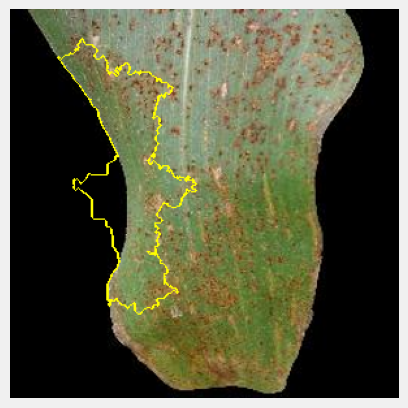

In [34]:
import lime
import lime.lime_image
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from skimage.segmentation import mark_boundaries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

model = InceptionV3(weights='imagenet')

explainer = lime.lime_image.LimeImageExplainer()

img = np.array(Image.open('/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Common_Rust/Corn_Common_Rust (1000).JPG').resize((299, 299)))
img = preprocess_input(img)

explanation = explainer.explain_instance(img, model.predict, top_labels=5, hide_color=0, num_samples=1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.axis('off')
plt.show()

# 20. Lime using MobileNetV2 Model

14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━

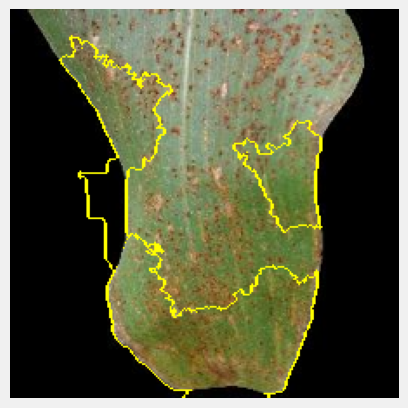

In [35]:
import lime
import lime.lime_image
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from skimage.segmentation import mark_boundaries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

model = MobileNetV2(weights='imagenet')

explainer = lime.lime_image.LimeImageExplainer()

img = np.array(Image.open('/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Common_Rust/Corn_Common_Rust (1000).JPG').resize((224, 224)))
img = preprocess_input(img)

explanation = explainer.explain_instance(img, model.predict, top_labels=5, hide_color=0, num_samples=1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.axis('off')
plt.show()

# 21. Lime using custom CNN model

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━

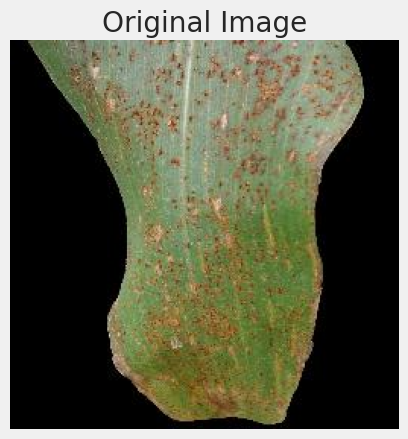

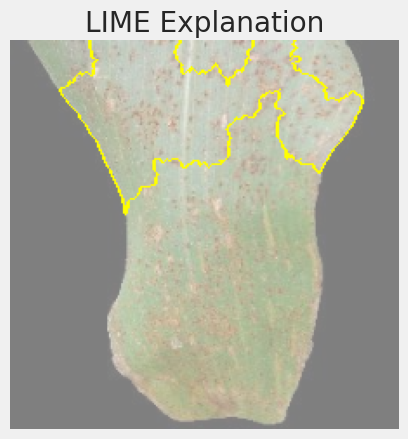

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.models import load_model
import tensorflow as tf

img_path = "/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Common_Rust/Corn_Common_Rust (1000).JPG"
img = plt.imread(img_path)

def preprocess_image(image):
    image = tf.image.resize(image, [224, 224])  
    image = tf.cast(image, tf.float32) / 255.0   
    return image.numpy()

preprocessed_img = preprocess_image(img)

model = load_model('/kaggle/working/model2.h5')

def predict_fn(images):
    processed_images = np.array([preprocess_image(image) for image in images])
    return model.predict(processed_images)

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(preprocessed_img, predict_fn, top_labels=5, hide_color=0, num_samples=1000)

plt.imshow(img)
plt.axis('off')
plt.title('Original Image')
plt.show()

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.axis('off')
plt.title('LIME Explanation')
plt.show()

# 22. Shap

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.37s/it]               


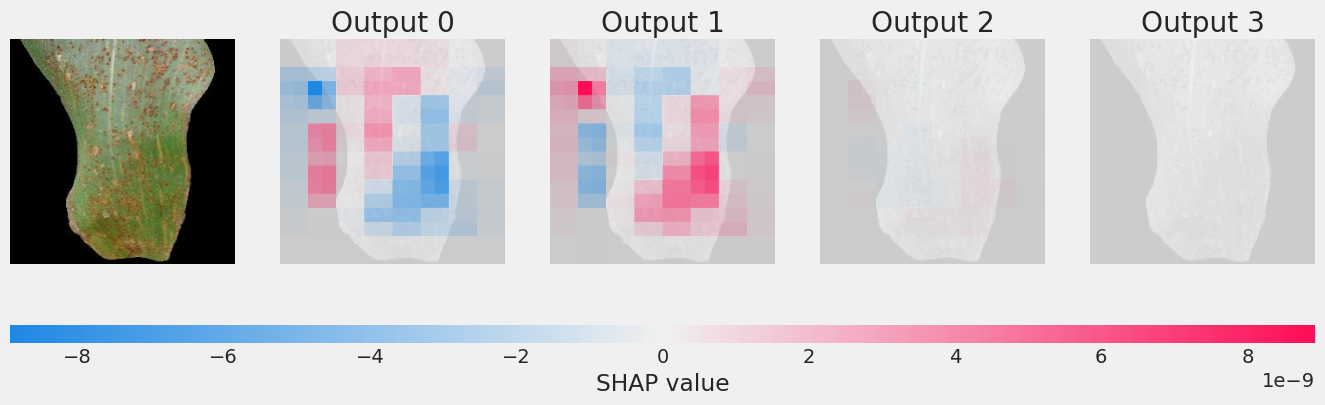

In [37]:
import os
import numpy as np
import tensorflow as tf
import shap
from tensorflow.keras.models import load_model

dataset_dir = "/kaggle/input/corn-or-maize-leaf-disease-dataset/data"

image_path = "/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Common_Rust/Corn_Common_Rust (1000).JPG"

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  
    image = tf.cast(image, tf.float32) / 255.0   
    return image.numpy()

image = preprocess_image(image_path)

model = load_model('/kaggle/working/model2.h5')

def f(x):
    tmp = x.copy()
    return model(tmp)

masker_blur = shap.maskers.Image("blur(224,224)", shape=(224, 224, 3))

explainer_blur = shap.Explainer(f, masker_blur)

shap_values_fine = explainer_blur(image[np.newaxis, :, :, :], max_evals=5000, outputs=shap.Explanation.argsort.flip[:4])

shap.image_plot(shap_values_fine)

# END!!! Thanks for Watching